# Which GPU to use

In [1]:
multiGPU = False
whichGPU = 1
 
# Select which GPU to use
if(multiGPU):
    from keras.utils.training_utils import multi_gpu_model
else:
    import os
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
    # The GPU id to use, usually either "0" or "1"
    os.environ["CUDA_VISIBLE_DEVICES"] = str(whichGPU)
    
# # Do other imports now...

# Load all the functions

In [2]:
%run -i 'arena.py'

Using TensorFlow backend.


In [3]:
# %load_ext autoreload
# %autoreload 1
# %aimport arena
# %reload_ext autoreload

# TRAINING TEMPLATE CODE


In [4]:
%reload_ext autoreload
##### TRAINING TEMPLATE CODE

##############################
#
#    PARAMETERS 
#
##############################
import math

# Experiment description
expDescr = "Experiment description text"

# What data to use
tableBase = '4PpKk'
convertStates = False
fractionOfDataToUse = 1 # [0,1]

# Interactive (just in general if one is asked for confirmations, set to False if on autopilot over night f.x.)
askForConfirmation = True

# Transfer Learning
loadWeights = False 
weightsSource = '024'
loadCheckpointWeights = False

# Plot during training
plotDuringTraining = True
compareResultsDuringTraining = False
compareWith = '013' # orginal net structure, trained from random on 4pc dataset


# NN parameters
# filters = [8,16,16,32,32]    #016:0.913  10kpm 2048:30                  8192:23:38% 32768:17:52% 
# filters = [8,16,32,64,128]   #005:0.952  50kpm 2048:37s    4096:28:50% 
# filters = [8,32,64,128,256]  #013:0.968 188kpm 2048:50s    4096:40s:61%             32768:46s:80% 65536:42s:99% 
# filters = [32,64,128,160,256]#014:0.974 388kpm 2048:3m:91% 
# filters = [16,32,64,128,128,128]#035:0.975 191kpm 2048:45s:50%/50% 2048:68s:78% 
# filters = [16,16,32,32,64,64,128] #054 70kpm
# filters = [16,16,32,32,64,64,128] #054 70kpm
filters = [16,32,32,64,128,128,128]
filterShape = [2,2,2,2,2,2,2]
batch_size = 256
epochs = 150
multiGPU = False
whichGPU = 0
# optimizer = 'Adam'
optimizer = 'Adadelta'
useBatchNorm = False

# Other paramters
confirmDirOverwrite = False
tPrintInterval = 0.5 # for print progress
yieldSize = 10000 # for load generator

### NO NEED TO MODIFY BELOW ###
# Generate dataset variables
fileName = tableBase + '.hdf5'
dataSetName = tableBase + '_onlyLegal'
if not convertStates: 
    dataSetName = tableBase + '_onlyLegal_fullStates'
dataSetWdlName = tableBase + '_Wdl_onlyLegal_3Values'

# Number of Pieces
nPi =  int(dataSetName[0])
nPa = nPi - 2
nWPa = math.ceil(nPa/2)

# Select which GPU to use
# if(multiGPU):
#     from keras.utils.training_utils import multi_gpu_model
# else:
#     import os
#     os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#     # The GPU id to use, usually either "0" or "1"
#     os.environ["CUDA_VISIBLE_DEVICES"] = str(whichGPU)
    
# Other NN stuff
num_classes = 3
input_shape = (4,8,8)


In [5]:
# Train, evaluate and save 
# %reload_ext autoreload
model, nnStr = createModel()
# resID = genNextResultsDir(model)
# X_train, X_test, y_train, y_test = loadData()
# score = calcScoreBigData(model)
# score = calcScore(model)
# saveTrainResults(resID, model, logDir, score)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 7, 7)          272       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 6, 32)         928       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 5, 32)         4128      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 4, 64)         8256      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 3, 128)        32896     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 11, 2, 128)        65664     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 1, 128)        65664     
__________

### many batches

In [ ]:
# Train and save with different paramters
X_train, X_test, y_train, y_test = loadData()

bs = [256,256,256,512,512,512,1024,1024,1024]

for batch_size in bs:
    expDescr = "Testing batch size effect for 70kpm network (7 CNN layers) {}bs".format(batch_size) 
    print("---------------------- batch size ", batch_size, '-------------------------------')
    model, nnStr = createModel()
    resID = genNextResultsDir(model)
    fitHistory, logDir = trainModel(resID, model)
    score = calcScore(model)
    saveTrainResults(resID, model, logDir)

# Bengio Template Code

In [19]:
# 3n4 noFreeze
%run -i 'arena.py'

# Parameters
sourceNet = '103'
freeze = False
epochs = 20
resSaveFile = '3n4plus'

fractionOfDataToUse = 1
plotDuringTraining = False
loadWeights = False 
askForConfirmation = False
saveDir = 'bengioResults'

X_train, X_test, y_train, y_test = loadData()
model, nnStr = createModel()
results = []
currentAverage = 0
averageOver = 
layersCount = len(model.layers)

for copyFirstNLayers in range(layersCount + 1):
    if copyFirstNLayers != layersCount - 1:
        model = loadNFirstLayers(model, sourceNet, copyFirstNLayers , freeze)

        resID = genNextResultsDir(model)
        #add freeze and some tl parameters to save dir

        # train
        fitHistory, logDir = trainModel(resID, model)

        # score and save accuracy
        score = calcScore(model)
        saveTrainResults(resID, model, logDir, score, copyFirstNLayers)
        results.append(score[1])

        # save results incrementally to txt file
        save_obj(bengioResults, resSaveFile, results)
        with open(bengioResults + '/' + str(resSaveFile) + '.txt','w') as file:
            file.write(str(results))
            
        # to load:
        # results = load_obj('temp','3n4.txt')
print(results)

X_train shape: (4982178, 4, 8, 8)
y_train shape: (4982178, 1)
X_test shape: (2453910, 4, 8, 8)
y_test shape: (2453910, 1)
4982178 train samples
2453910 test samples
Done loading dataset
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 16, 7, 7)          272       
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 15, 6, 32)         928       
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 14, 5, 32)         4128      
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 13, 4, 64)         8256      
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 12, 3, 128)        32896     
_________________________________________________________________
conv2d_48 (Conv2D)    

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

# Experiments

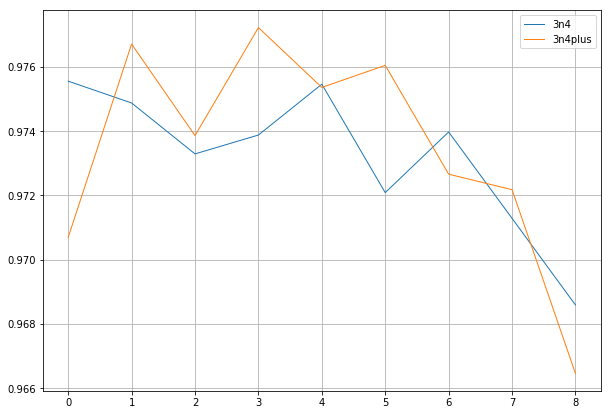

In [27]:
# plot Bengio 

# load results
resSaveFile = '3n4'
saveDir = 'bengioResults'
acc3n4 = load_obj(saveDir,resSaveFile)

resSaveFile = '3n4plus'
saveDir = 'bengioResults'
acc3n4plus = load_obj(saveDir,resSaveFile)


# plot results
AnB = acc3n4
AnBplus = acc3n4plus
x = [i for i in range(len(AnB))]
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.plot(x,AnB, label = '3n4', linewidth = 1)
ax.plot(x,AnBplus, label = '3n4plus', linewidth = 1)
ax.legend()
ax.grid(True)
                

In [47]:
# 3n4 Freeze
%run -i 'arena.py'

# Parameters
sourceNet = '103'
freeze = True
resSaveFile = '3n4plus'
epochs = 1
averageOver = 3 
expDescr = "Bengio - freeze = {} - average over {} runs".format(str(freeze), averageOver)

saveEveryRun = False # save stuff in results dir
saveWeightsCheckpoints = False # save chkp in results dit
saveTensorboardLogs = False # save logs in ./logs dir
resSaveFile = resSaveFile + '-{} run average'.format(averageOver)
fractionOfDataToUse = 0.01
plotDuringTraining = False
loadWeights = False 
askForConfirmation = False
saveDir = 'bengioResults'

X_train, X_test, y_train, y_test = loadData()
model, nnStr = createModel()
results = []
accumulatedScore = 0
layersCount = len(model.layers)

for copyFirstNLayers in range(layersCount + 1):
    print('=========== At layer {} of {} ==========='.format(copyFirstNLayers, layersCount - 1))
    if copyFirstNLayers != layersCount - 1:
        accumulatedScore = 0
        for a in range(averageOver):
            model = loadNFirstLayers(model, sourceNet, copyFirstNLayers , freeze)

            if saveEveryRun:
                resID = genNextResultsDir(model)
                #add freeze and some tl parameters to save dir

            # train
            fitHistory, logDir = trainModel(resID, model, saveWeightsCheckpoints, saveTensorboardLogs)

            # score and save accuracy
            score = calcScore(model)
            if saveEveryRun:
                saveTrainResults(resID, model, logDir, score, copyFirstNLayers)
            
            # update Return
            accumulatedScore += score[1]
        results.append(accumulatedScore/averageOver)

        # save results incrementally to txt file
        save_obj(saveDir, resSaveFile, results)
        with open(saveDir + '/' + str(resSaveFile) + '.txt','w') as file:
            file.write(str(results))
            
        # to load:
        # results = load_obj('temp','3n4.txt')
print('/n Final Results: results')

X_train shape: (49821, 4, 8, 8)
y_train shape: (49821, 1)
X_test shape: (24539, 4, 8, 8)
y_test shape: (24539, 1)
49821 train samples
24539 test samples
Done loading dataset
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_176 (Conv2D)          (None, 16, 7, 7)          272       
_________________________________________________________________
conv2d_177 (Conv2D)          (None, 15, 6, 32)         928       
_________________________________________________________________
conv2d_178 (Conv2D)          (None, 14, 5, 32)         4128      
_________________________________________________________________
conv2d_179 (Conv2D)          (None, 13, 4, 64)         8256      
_________________________________________________________________
conv2d_180 (Conv2D)          (None, 12, 3, 128)        32896     
_________________________________________________________________
conv2d_181 (Conv2D)          (None

/home/frimann/anaconda3/envs/endnetGpu/lib/python3.5/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Train on 49821 samples, validate on 24539 samples
Epoch 1/1
49821/49821 [==============================] - 4s 73us/step - loss: 0.9411 - acc: 0.5274 - val_loss: 0.8195 - val_acc: 0.6341
Training done
Calculating score
24539/24539 [==============================] - 2s 68us/step
(49821, 4, 8, 8)
Evaluated test loss: 0.8194782437873628
Evaluated test accuracy: 0.6341334202576298
Loading first 0 layers from results Results/103/weights.hdf5, 
- Resetting layer nr 1: <keras.layers.convolutional.Conv2D object at 0x7f38480503c8>
- Resetting layer nr 2: <keras.layers.convolutional.Conv2D object at 0x7f38481db668>
- Resetting layer nr 3: <keras.layers.convolutional.Conv2D object at 0x7f3836defd68>
- Resetting layer nr 4: <keras.layers.convolutional.Conv2D object at 0x7f3836f571d0>
- Resetting layer nr 5: <keras.layers.convolutional.Conv2D object at 0x7f3836fb8a58>
- Resetting layer nr 6: <keras.layers.convolutional.Conv2D object at 0x7f3836f4fef0>
- Resetting layer nr 7: <keras.layers.convolutio

49821/49821 [==============================] - 2s 38us/step - loss: 0.8924 - acc: 0.5653 - val_loss: 0.7094 - val_acc: 0.6832
Training done
Calculating score
24539/24539 [==============================] - 2s 66us/step
(49821, 4, 8, 8)
Evaluated test loss: 0.7094065823236894
Evaluated test accuracy: 0.6832389257721653
=========== At layer 3 of 8 ===========
Loading first 3 layers from results Results/103/weights.hdf5, 
- Resetting layer nr 4: <keras.layers.convolutional.Conv2D object at 0x7f3836f571d0>
- Resetting layer nr 5: <keras.layers.convolutional.Conv2D object at 0x7f3836fb8a58>
- Resetting layer nr 6: <keras.layers.convolutional.Conv2D object at 0x7f3836f4fef0>
- Resetting layer nr 7: <keras.layers.convolutional.Conv2D object at 0x7f3848108780>
- Skipping layer nr 8: <keras.layers.core.Flatten object at 0x7f38480ffeb8>
- Resetting layer nr 9: <keras.layers.core.Dense object at 0x7f3837919ba8>
Train on 49821 samples, validate on 24539 samples
Epoch 1/1
49821/49821 [==============

49821/49821 [==============================] - 2s 38us/step - loss: 0.7290 - acc: 0.6808 - val_loss: 0.5539 - val_acc: 0.7677
Training done
Calculating score
24539/24539 [==============================] - 2s 66us/step
(49821, 4, 8, 8)
Evaluated test loss: 0.5538778462329914
Evaluated test accuracy: 0.7677166958694485
Loading first 6 layers from results Results/103/weights.hdf5, 
- Resetting layer nr 7: <keras.layers.convolutional.Conv2D object at 0x7f3848108780>
- Skipping layer nr 8: <keras.layers.core.Flatten object at 0x7f38480ffeb8>
- Resetting layer nr 9: <keras.layers.core.Dense object at 0x7f3837919ba8>
Train on 49821 samples, validate on 24539 samples
Epoch 1/1
49821/49821 [==============================] - 2s 38us/step - loss: 0.7213 - acc: 0.6837 - val_loss: 0.5115 - val_acc: 0.7886
Training done
Calculating score
24539/24539 [==============================] - 2s 65us/step
(49821, 4, 8, 8)
Evaluated test loss: 0.5114826017945848
Evaluated test accuracy: 0.7885814418011178
Loa

In [42]:
# Train, evaluate and save 
%run -i 'arena.py'
# %reload_ext autoreload
plotDuringTraining = True
fractionOfDataToUse = 0.01
model, nnStr = createModel()
# resID = genNextResultsDir(model)
X_train, X_test, y_train, y_test = loadData()
fitHistory, logDir = trainModel(resID, model)
# score = calcScoreBigData(model)
# score = calcScore(model)
# saveTrainResults(resID, model, logDir, score)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_148 (Conv2D)          (None, 16, 7, 7)          272       
_________________________________________________________________
conv2d_149 (Conv2D)          (None, 15, 6, 32)         928       
_________________________________________________________________
conv2d_150 (Conv2D)          (None, 14, 5, 32)         4128      
_________________________________________________________________
conv2d_151 (Conv2D)          (None, 13, 4, 64)         8256      
_________________________________________________________________
conv2d_152 (Conv2D)          (None, 12, 3, 128)        32896     
_________________________________________________________________
conv2d_153 (Conv2D)          (None, 11, 2, 128)        65664     
_________________________________________________________________
conv2d_154 (Conv2D)          (None, 10, 1, 128)        65664     
__________

UnboundLocalError: local variable 'initWeightsId' referenced before assignment